<h1>ARIMA Model</h1>
<p>
    Models generated using statmodels. Datasets gathered from <a href = "https://www.coindesk.com/">CoinDesk.</a>
    <br/> <br/>
    Autoregressive integrated moving average - ARIMA - is a time series model that predicts future value(s) derived from past data.
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as ma
from IPython import get_ipython
import datetime as dt

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings

warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
def days_prior(df: pd.DataFrame, days: int, time_frame: int = 0) -> pd.DataFrame:

    epoch = len(df.index) - ma.floor(days)

    if time_frame == 0.0:

        return df[(df.index >= epoch)]

    else:
        
        end = epoch + ma.floor(time_frame)

        return df[(df.index >= epoch) & (df.index < end)]
        

def get_csv(path: str) -> pd.DataFrame:

    df = pd\
        .read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price'})\
        .set_index('date')

    df = df.asfreq(pd.infer_freq(df.index))

    return df


In [3]:
df_eth  = get_csv('../data/Ethereum.csv')
df_ada  = get_csv('../data/Cardano.csv')
df_doge = get_csv('../data/Dogecoin.csv')
df_sol  = get_csv('../data/Solana.csv')

<h3>Augmented Dickey Fuller Test (ADF Test)</h3>
<p>p-value should be << 0.05</p>

In [11]:
result = adfuller(df_ada.diff().dropna())

print(f'p-value: {result[1]}')

p-value: 2.0694026249646475e-30


<h2>ADA coin</h2>


<h4>Stationary test</h4>
<p>
    For time series analysis to work well, the time series data should be stationary. We can gauge it by ploting the ACF (Autocorrelation function) which asserts how much a lag affect the current value, the autocorrelation value ranges from 1 to -1, a lag with autocorrelation value of 1 is said to affect the current value by 100%.
    <br/>
    When we ploted the ACF for ada dataset a sin-like graph appear. This indicates that the data is not stationary; thus, a differencing is needed.
</p>

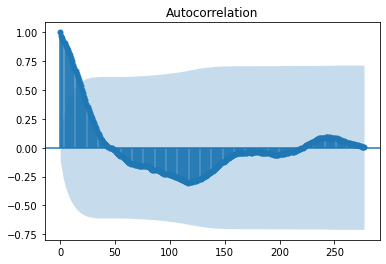

In [27]:
plot_acf(df_ada, lags = len(df_ada.index) - 1)
plt.show()

<h4>1st Order Differencings</h4>
<p>
    Differencing is done by subtracting the first lag of a value.
    <br/>
    With the 1st order differencings, we can observe that the ACF plot no longer exhibits the sin-like pattern; the dataset is now stationary.
</p>

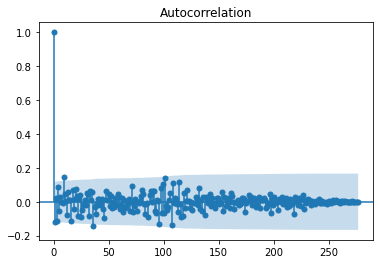

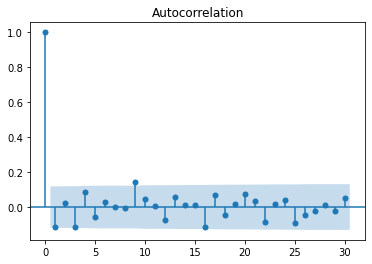

In [36]:
plot_acf(df_ada.diff().dropna(), lags = len(df_ada.index) - 2)
plot_acf(df_ada.diff().dropna(), lags = 30)
plt.show()

<h3>Rolling Forecast</h3>

In [7]:
def rolling_forecast(df: pd.DataFrame, order = (1, 1, 1), test_ratio: float = 0.3) -> dict:

    prediction_roll = pd.Series(dtype = 'float64')

    test_data = df[ma.floor(len(df.index) * (1 - test_ratio)) + 1:]

    for end_date in test_data.index:

        train_data = df[:end_date - dt.timedelta(days = 1)]
        model = ARIMA(train_data, order = order)
        model_fit = model.fit()
        pred = model_fit.predict(end_date)
        prediction_roll.loc[end_date] = pred.loc[end_date]

    return {'pred': prediction_roll, 'real': test_data}

In [8]:
rolling_value = rolling_forecast(df_ada, (1,1,1))
real = rolling_value['real']
pred = rolling_value['pred']

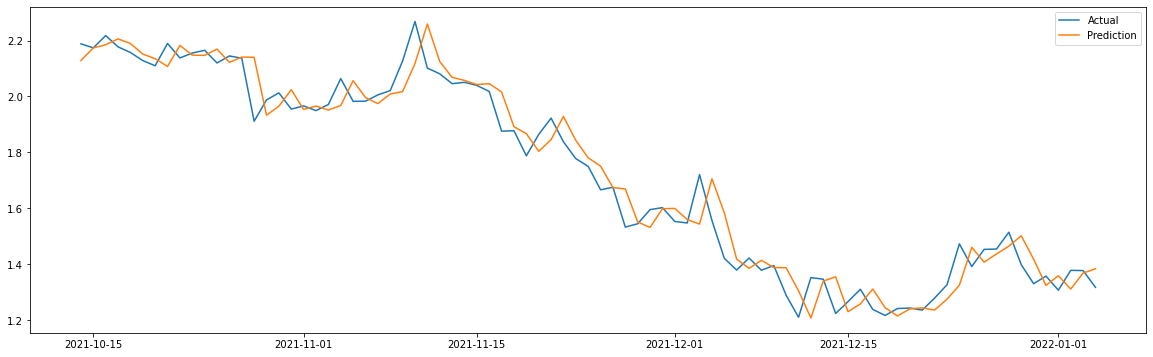

In [9]:
plt.figure(figsize=(20,6))
plt.plot(real, label = 'Actual')
plt.plot(pred, label = 'Prediction')
plt.legend(loc = 'best')
plt.show()